In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_csv('/content/drive/My Drive/Healthcare Analytics/train.csv')
test = pd.read_csv('/content/drive/My Drive/Healthcare Analytics/test.csv')

In [3]:
train.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  int64  
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  int64  
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient                  3139

In [5]:
features_with_na=[features for features in train.columns if train[features].isnull().sum()>1]
## 2- step print the feature name and the percentage of missing values

for feature in features_with_na:
    print(feature, np.round(train[feature].isnull().mean(), 4),  ' % missing values')

Bed Grade 0.0004  % missing values
City_Code_Patient 0.0142  % missing values


In [6]:
test.isnull().sum().sort_values(ascending= False)

City_Code_Patient                    2157
Bed Grade                              35
Admission_Deposit                       0
Department                              0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Ward_Facility_Code                      0
Ward_Type                               0
Age                                     0
patientid                               0
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
case_id                                 0
dtype: int64

In [7]:
train.shape

(318438, 18)

In [8]:
test.shape

(137057, 17)

In [9]:
for i in train.columns:
  print(i,' : ' , train[i].nunique())

case_id  :  318438
Hospital_code  :  32
Hospital_type_code  :  7
City_Code_Hospital  :  11
Hospital_region_code  :  3
Available Extra Rooms in Hospital  :  18
Department  :  5
Ward_Type  :  6
Ward_Facility_Code  :  6
Bed Grade  :  4
patientid  :  92017
City_Code_Patient  :  37
Type of Admission  :  3
Severity of Illness  :  3
Visitors with Patient  :  28
Age  :  10
Admission_Deposit  :  7300
Stay  :  11


In [10]:
for i in test.columns:
  print(i,' : ' , test[i].nunique())

case_id  :  137057
Hospital_code  :  32
Hospital_type_code  :  7
City_Code_Hospital  :  11
Hospital_region_code  :  3
Available Extra Rooms in Hospital  :  15
Department  :  5
Ward_Type  :  6
Ward_Facility_Code  :  6
Bed Grade  :  4
patientid  :  39607
City_Code_Patient  :  37
Type of Admission  :  3
Severity of Illness  :  3
Visitors with Patient  :  27
Age  :  10
Admission_Deposit  :  6609


In [11]:
train['Bed Grade'].fillna(train['Bed Grade'].mode()[0], inplace = True)
test['Bed Grade'].fillna(test['Bed Grade'].mode()[0], inplace = True)

In [12]:
train['City_Code_Patient'].fillna(train['City_Code_Patient'].mode()[0], inplace = True)
test['City_Code_Patient'].fillna(test['City_Code_Patient'].mode()[0], inplace = True)

In [13]:
test['Stay'] = -1
df = pd.concat([train, test])
df.shape

(455495, 18)

In [14]:
from sklearn.preprocessing import LabelEncoder

for i in ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code', 'Type of Admission', 'Severity of Illness', 'Age']:
    le = LabelEncoder()
    df[i] = le.fit_transform(df[i].astype('str'))

In [15]:
train = df[df['Stay']!=-1]
test = df[df['Stay']==-1]

In [16]:
le = LabelEncoder()
train['Stay'] = le.fit_transform(train['Stay'].astype('str'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
def get_countid_enocde(train, test, cols, name):
  temp = train.groupby(cols)['case_id'].count().reset_index().rename(columns = {'case_id': name})
  temp2 = test.groupby(cols)['case_id'].count().reset_index().rename(columns = {'case_id': name})
  train = pd.merge(train, temp, how='left', on= cols)
  test = pd.merge(test,temp2, how='left', on= cols)
  train[name] = train[name].astype('float')
  test[name] = test[name].astype('float')
  train[name].fillna(np.median(temp[name]), inplace = True)
  test[name].fillna(np.median(temp2[name]), inplace = True)
  return train, test

In [18]:
train, test = get_countid_enocde(train, test, ['patientid'], name = 'count_id_patient')
train, test = get_countid_enocde(train, test, ['patientid', 'Hospital_region_code'], name = 'count_id_patient_hospitalCode')
train, test = get_countid_enocde(train, test, ['patientid', 'Ward_Facility_Code'], name = 'count_id_patient_wardfacilityCode')

In [19]:
train.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,count_id_patient,count_id_patient_hospitalCode,count_id_patient_wardfacilityCode
0,1,8,2,3,2,3,3,2,5,2.0,31397,7.0,0,0,2,5,4911.0,0,14.0,4.0,5.0
1,2,2,2,5,2,2,3,3,5,2.0,31397,7.0,1,0,2,5,5954.0,4,14.0,4.0,5.0
2,3,10,4,1,0,2,1,3,4,2.0,31397,7.0,1,0,2,5,4745.0,3,14.0,4.0,2.0
3,4,26,1,2,1,2,3,2,3,2.0,31397,7.0,1,0,2,5,7272.0,4,14.0,6.0,3.0
4,5,26,1,2,1,2,3,3,3,2.0,31397,7.0,1,0,2,5,5558.0,4,14.0,6.0,3.0


In [20]:
test = test.drop(['Stay', 'patientid', 'Hospital_region_code', 'Ward_Facility_Code'], axis =1)
train = train.drop(['case_id', 'patientid', 'Hospital_region_code', 'Ward_Facility_Code'], axis =1)

In [21]:
import xgboost
classifier=xgboost.XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=800, objective='multi:softmax',reg_alpha=0.5, reg_lambda=1.5,
                                 booster='gbtree', n_jobs=4, min_child_weight=2, base_score= 0.75)

In [22]:
X = train.drop('Stay', axis =1)
y = train['Stay']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25, random_state =100)

In [23]:
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.75, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=2, missing=None, n_estimators=800, n_jobs=4,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0.5, reg_lambda=1.5, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [24]:
prediction=classifier.predict(X_test)
from sklearn.metrics import confusion_matrix,accuracy_score
cm=confusion_matrix(prediction,y_test)
acc_score=accuracy_score(prediction,y_test)
print(acc_score*100)

43.27345810827786


###Predictions

In [25]:
pred = classifier.predict(test.iloc[:,1:])
submissions = pd.DataFrame(pred, columns=['Stay'])
submissions['case_id'] = test['case_id']
submissions = submissions[['case_id', 'Stay']]

In [26]:
submissions['Stay'] = submissions['Stay'].replace({0:'0-10', 1: '11-20', 2: '21-30', 3:'31-40', 4: '41-50', 5: '51-60', 6: '61-70', 7: '71-80', 8: '81-90', 9: '91-100', 10: 'More than 100 Days'})

In [27]:
submissions.head()

,case_id,Stay
0,318439,0-10
1,318440,51-60
2,318441,21-30
3,318442,21-30
4,318443,51-60


In [28]:
from google.colab import files
submissions.to_csv('submissions_new2.csv', index=False) 
files.download('submissions_new2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
X = train.drop('Stay', axis =1)
y = train['Stay']

In [30]:
dtrain = xgboost.DMatrix(X, label=y)

In [31]:
def train_xgb(max_depth =6, num_round =1000, seed=0):
  param ={
      'max_depth': max_depth,
      'eta': 0.1,
      'silent':1,
      'objective': 'multi:softmax',
      'eval_metric': 'merror',
      'num_class': 11,
      'seed': seed
  }
  num_round = num_round
  bst = xgboost.train(param, dtrain, num_round)
  return bst

In [32]:
bst=train_xgb(4,200,0)

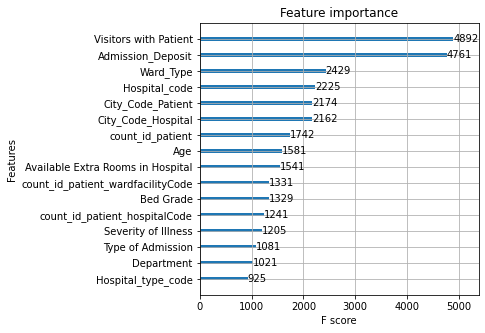

In [33]:
from xgboost import plot_importance
_,ax = plt.subplots(1,1,figsize=(5,5))
plot_importance(bst,ax)